In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
# from wordcloud import WordCloud
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the dataset

In [2]:
# Load the dataset
file_path_1 = 'data_2022.csv'
file_path_2 = 'data_2021.csv'
file_path_3 = 'data_2020.csv'
file_path_4 = 'data_2019.csv'
file_path_5 = 'data_2018.csv'

# Read each CSV file into a dataframe
df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)
df4 = pd.read_csv(file_path_4)
df5 = pd.read_csv(file_path_5)

# Concatenate the dataframes
data = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# Print the combined dataframe
print(data)

           user_id    bill_id  line_item_amount  bill_discount  \
0        519644808  741961800          559.6000            0.0   
1        519644808  741961800          559.6000            0.0   
2        504795522  692673877          699.5000            0.0   
3         12626591  768369011          519.6000            0.0   
4         12626591  768369011          519.6000            0.0   
...            ...        ...               ...            ...   
8454378  411973512  430742644         1825.3281            0.0   
8454379  411973512  430742644         1825.3281            0.0   
8454380  411973512  430742644         1825.3281            0.0   
8454381  275148389  428988128         1470.0000            0.0   
8454382  343405060  432088540         1149.0000         1700.0   

        transaction_date                                   description  \
0             2022-04-20         MBL ITA16BLT004 Regular Casual Tan 32   
1             2022-04-20         MBL ITA16BLT004 Regular Ca

# Check for missing values

In [3]:
data.head()

,user_id,bill_id,line_item_amount,bill_discount,transaction_date,description,inventory_category,colour,size,zone_name,store_name,year
0,519644808,741961800,559.6,0.0,2022-04-20,MBL ITA16BLT004 Regular Casual Tan 32,MENS BELT,Tan,32,North,North_6023,2022
1,519644808,741961800,559.6,0.0,2022-04-20,MBL ITA16BLT004 Regular Casual Tan 32,MENS BELT,Tan,32,North,North_6023,2022
2,504795522,692673877,699.5,0.0,2022-01-27,MBL ITA16BLT004 Regular Casual Tan 34,MENS BELT,Tan,34,East,East_6510,2022
3,12626591,768369011,519.6,0.0,2022-10-09,MBL ITA16BLT001 Regular Casual Dark Brown 32,MENS BELT,Dark Brown,32,South,South_6017,2022
4,12626591,768369011,519.6,0.0,2022-10-09,MBL ITA16BLT001 Regular Casual Dark Brown 32,MENS BELT,Dark Brown,32,South,South_6017,2022


In [4]:
# Display the initial state of missing values
print("Initial Missing Values:\n", data.isnull().sum())

Initial Missing Values:
 user_id                    0
bill_id                    0
line_item_amount           0
bill_discount              0
transaction_date           0
description               17
inventory_category    697444
colour                 15555
size                   15555
zone_name                  0
store_name                 0
year                       0
dtype: int64


# Dropping the duplicates

dropping duplicates for exact items.

In [5]:
# Display the number of rows before removing duplicates
print("Number of rows before removing duplicates:", len(data))

# Identify duplicates: This will mark rows as True if they are duplicates
duplicates = data.duplicated()
print("\nNumber of duplicate rows:", duplicates.sum())

# Optional: Review some of the duplicate rows
print("\nPreview of duplicate rows:")
print(data[duplicates].head())

# Remove duplicates: This keeps the first occurrence and removes subsequent duplicate rows
data = data.drop_duplicates()

# Display the number of rows after removing duplicates
print("\nNumber of rows after removing duplicates:", len(data))

Number of rows before removing duplicates: 8454383

Number of duplicate rows: 1898076

Preview of duplicate rows:
     user_id    bill_id  line_item_amount  bill_discount transaction_date  \
1  519644808  741961800             559.6            0.0       2022-04-20   
4   12626591  768369011             519.6            0.0       2022-10-09   
5   12626591  768369011             519.6            0.0       2022-10-09   
6   12626591  768369011             519.6            0.0       2022-10-09   
7   12626591  768369011             519.6            0.0       2022-10-09   

                                    description inventory_category  \
1         MBL ITA16BLT004 Regular Casual Tan 32          MENS BELT   
4  MBL ITA16BLT001 Regular Casual Dark Brown 32          MENS BELT   
5  MBL ITA16BLT001 Regular Casual Dark Brown 32          MENS BELT   
6  MBL ITA16BLT001 Regular Casual Dark Brown 32          MENS BELT   
7  MBL ITA16BLT001 Regular Casual Dark Brown 32          MENS BELT   

  

# Extracting Product from descriptions

In [6]:
# Function to extract product name based on the pattern
def get_product(txt, pattern):
    if isinstance(txt, str):
        # Search and check if split word exists
        searched_word = re.search(pattern, txt)
        # Word exists
        if searched_word:
            splitted_string = re.split(pattern, txt)[0]
            # Check if empty list is returned (when there is only pattern available in 'txt')
            if splitted_string == '':
                return 'Unknown'
            else:
                return splitted_string.strip()
        # Split word not exists (but the product name can still be present, so we'll need the entire string)
        else:
            return txt
    # Any other value found other than string datatype
    else:
        return 'Unknown'

# Copying 'description' column
data['desc_copy'] = data['description'].copy()
data['desc_copy'] = data['desc_copy'].fillna('Unknown')

# Apply get_product function for patterns starting with IT, CORE-, A16-, A17-, S16-, S18-, TBA07SD7890 (LENGTH=11)
data['product'] = data['desc_copy'].apply(lambda row: get_product(row, pattern=r'IT[A-Z0-9]+|CORE-|\b[A-Z]\d{2}-|\b[A-Z0-9]{11}\b'))

# Product names as acronyms are their lengths are not greater than 2.
data['product'] = data['product'].apply(lambda row: 'Unknown' if len(row.split()) >= 2 else row)

# Removing inconsistent data
data['product'] = data['product'].apply(lambda row: 'Unknown' if re.search(r'\d+|size|name|bill|amount|quantity|email|address|number|city|state|country|code|customer|discount|sex', row, flags=re.IGNORECASE) else row)

In [7]:
# removing more inconsistent data
invalid_vals = ['CALandLine', 'CAMobile', 'Cashier','PendingOrders','DOB', 'DOA', 'LastVisit', 'Points',
'Anniversary', 'CashierMBO','OrderCashier','CreditLimit',
'DateOfAnniversary', 'OtherDetails', 'IsReminderRequired',
'AgreeToReceiveSMS', 'Gender', 'AwarenessSourceRemarks',
'AllowCredit', 'CreditDays', 'AgreeToReceiveCall', 'DateOfBirth','Administrator','MRPValue','CGST', 'BatchDescription',
'TaxDescription', 'IsActive', 'CardExpiryDate','DealerType','DND','DEFAULT']

data[['product']] = data[['product']].applymap(lambda val: 'Unknown' if val in invalid_vals else val)

# Handling missing values for inventory category, colors and size

In [8]:
data['ic_copy'] = data['inventory_category'].copy()
data['ic_copy'] = data['ic_copy'].fillna('Unknown')
data[['ic_copy']] = data[['ic_copy']].applymap(lambda row: re.sub(r'na','',row,flags=re.IGNORECASE))

data['colour'] = data['colour'].fillna('Unknown')
data['colour'] = data['colour'].str.replace('NOT-CAPTURED','Unknown')

data['size'] = data['size'].fillna('Unknown')
data['size'] = data['size'].str.replace('NOT-CAPTURED','Unknown')

# Handling missing values for color

In [9]:
all_colours = data['colour'].value_counts().index.tolist()
pattern = r'\b(?:' + '|'.join(re.escape(color)  for color in all_colours if isinstance(color,str)) + r')\b'

def find(txt,pattern):
    x = re.findall(pattern, txt,flags=re.IGNORECASE)
    if x==[]:
        return ('Unknown')
    return ' '.join(x)

print('Unique colours count before:',len(data['colour'].unique()))

unknown_colours_bef = data[data['colour']=='Unknown'].shape[0]
data.loc[(data['colour']=='Unknown'),'colour'] = data.loc[(data['colour']=='Unknown'),'ic_copy'].map(lambda row: find(row,pattern))
unknown_colours_after = data[data['colour']=='Unknown'].shape[0]
print('Colours found: ',unknown_colours_bef - unknown_colours_after)

print('Unique colours count after:',len(data['colour'].unique()))

Unique colours count before: 402
Colours found:  1859280
Unique colours count after: 457


# Handling missing values for size

In [10]:
def find_size(txt,pattern):
    try:

        x = re.findall(pattern,txt,flags=re.IGNORECASE)
        if x==[]:
            return ('Unknown')

        x =  ', '.join(x)
        if x != '':
            return (txt.split(x)[1])
    except:
        return 'Unknown'

print('Unique sizes before:',len(data['size'].unique()))

unknown_size_bef = data[data['size']=='Unknown'].shape[0]
data.loc[(data['size']=='Unknown'),'size'] = data.loc[(data['size']=='Unknown'),'ic_copy'].map(lambda row: find_size(row,r'Size'))
#some rows contains sizes seperated by ( , ) like m,s  which is incorrect as at a time a product can have only 1 size
data[['size']] = data[['size']].applymap(lambda x: x.split(' ')[-1].strip() if ' ' in x else x)
unknown_size_after = data[data['size']=='Unknown'].shape[0]
print('Sizes found: ',unknown_size_bef - unknown_size_after)

print('Unique sizes after:',len(data['size'].unique()))

Unique sizes before: 68
Sizes found:  17465
Unique sizes after: 82


In [11]:
print(data['size'].unique())

['32' '34' 'L' 'S' 'XL' '38' '36' 'M' '30' '28' '2XL' 'ES' 'EES' '40' '42'
 '3XL' 'EL' '4XL' 'Unknown' 'EEL' '44' 'Foot' '18CM' '46' 'XS' '50' '6XL'
 '5XL' '52' '48' '23CM' '24CM' '23Y' '45Y' '1516Y' '11Y' '23cm' '1314Y'
 '1112Y' '54' 'Length' '67Y' '1011Y' '89Y' '40CM' '54cm' '20CM' '8'
 'DEFAULT' '22CM' '(23x6x28)' '(32x19x48)' '112CM' 'Free' '(45x23x27)'
 'SColorBlue' '117CM' '97CM' '102CM' '107CM' '92CM' 'Show' 'cm' '77CM'
 '87CM' '10' '9' '38CM' '42CM' '82CM' '46CM' 'XXL' '31CM' 'FootLt22CM'
 '24' '35CM' 'BAG' '7' '48CM' '44CM' '67CM' '11']


# Replacing abbreviations of products

In [12]:
replace = {'TR':'MENS TROUSER',
'MSP':'MENS SPORTSCOAT',
'BSP':'MENS SPORTSCOAT',
'TWB': 'MENS TROUSER WITH BELT',
'JKT': 'MENS JACKET',
'SH':'MENS SHIRT',
'MSH':'MENS SHIRT',
'MTR':'MENS TROUSER WITH BELT',
'MBL':'MENS BELT',
'BLT':'MENS BELT',
'SR':'MENS SHORTS',
'MTS':'MENS T-SHIRT',
'TS':'MENS T-SHIRT',
'BSH':'BOYS SHIRT',
'SW':'MENS SWEATER',
'BDE':'BOYS DENIM',
'MFW':'MENS FOOTWEAR',
'FW':'MENS FOOTWEAR',
'BDNM':'BOYS DENIM',
'SX':'MENS SOCKS',
'MSO':'MENS SHORTS',
'SO':'MENS SHORTS',
'MDE':'MENS DENIM',
'BTS':'BOYS T-SHIRT',
'BSO':'BOYS SHORTS',
'MDNM':'MENS DENIM',
'BTR':'BOYS TROUSER',
'MSW':'MENS SWEATER',
'SCKS':'MENS SOCKS',
'MSX':'MENS SOCKS',
'BSW':'BOYS SWEATER',
'MJKT':'MENS JACKET',
'MJA':'MENS JACKET',
'BJKT':'BOYS JACKET',
'BJO':'BOYS Jogger',
'MSC':'MENS JACKET',
'BS':'BOYS SHIRT',
'MWL':'Mens Wallet - Sportswear',
'BJA':'BOYS JACKET',
'BSR':'BOYS SHORTS',
'MDN':'MENS Denim Trouser',
'BDN':'Boys Denim Trouser - Jeanswear',
'KT':'MENS KNIT TROUSER',
'MJGR':'MENS JOGGER',
'TBG':'Trolley Bag',
'CBG':'CARRY BAG',
'MTIE':'MALE TIE',
'MJO':'MENS JOGGER',
'MWC':'MENS BANDI'}

data['product'] = data['product'].map(lambda x: replace[x] if x in replace.keys() else x)

In [13]:
print(data.head(10))

      user_id    bill_id  line_item_amount  bill_discount transaction_date  \
0   519644808  741961800          559.6000            0.0       2022-04-20   
2   504795522  692673877          699.5000            0.0       2022-01-27   
3    12626591  768369011          519.6000            0.0       2022-10-09   
10  496507098  779140853          559.6000            0.0       2022-11-10   
12  518922122  740235900          937.1713            0.0       2022-07-04   
13  265821333  741719450         1243.0383            0.0       2022-04-08   
15  505086766  693993536         1384.2867            0.0       2022-02-02   
16  519752413  742055389         2999.5000            0.0       2022-04-22   
17  519068031  740843639         1063.0603            0.0       2022-07-06   
19  357496939  747217849         1449.5000            0.0       2022-07-28   

                                     description inventory_category  \
0          MBL ITA16BLT004 Regular Casual Tan 32          MENS BELT   

# Extracting Date, Year , Month, Day of Week(Feature Engineering)

In [14]:
# Ensure 'transaction_date' is in datetime format
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Feature Engineering
# Extracting year, month, and day
data['year'] = data['transaction_date'].dt.year
data['month'] = data['transaction_date'].dt.month
data['day'] = data['transaction_date'].dt.day

# Extracting day of the week (Monday=0, Sunday=6)
data['day_of_week'] = data['transaction_date'].dt.dayofweek

# Optionally, extract more features like quarter, day of the year, etc.
data['quarter'] = data['transaction_date'].dt.quarter
data['day_of_year'] = data['transaction_date'].dt.dayofyear

# Preview the modified dataframe
print(data.head())

      user_id    bill_id  line_item_amount  bill_discount transaction_date  \
0   519644808  741961800          559.6000            0.0       2022-04-20   
2   504795522  692673877          699.5000            0.0       2022-01-27   
3    12626591  768369011          519.6000            0.0       2022-10-09   
10  496507098  779140853          559.6000            0.0       2022-11-10   
12  518922122  740235900          937.1713            0.0       2022-07-04   

                                     description inventory_category  \
0          MBL ITA16BLT004 Regular Casual Tan 32          MENS BELT   
2          MBL ITA16BLT004 Regular Casual Tan 34          MENS BELT   
3   MBL ITA16BLT001 Regular Casual Dark Brown 32          MENS BELT   
10         MBL ITS17BLT005 Regular Casual Tan 34          MENS BELT   
12             BSW TBA17SWK607 Regular LS Navy L       BOYS SWEATER   

        colour size zone_name  store_name  year  \
0          Tan   32     North  North_6023  2022   
2 

In [15]:
print(data.head(10))

      user_id    bill_id  line_item_amount  bill_discount transaction_date  \
0   519644808  741961800          559.6000            0.0       2022-04-20   
2   504795522  692673877          699.5000            0.0       2022-01-27   
3    12626591  768369011          519.6000            0.0       2022-10-09   
10  496507098  779140853          559.6000            0.0       2022-11-10   
12  518922122  740235900          937.1713            0.0       2022-07-04   
13  265821333  741719450         1243.0383            0.0       2022-04-08   
15  505086766  693993536         1384.2867            0.0       2022-02-02   
16  519752413  742055389         2999.5000            0.0       2022-04-22   
17  519068031  740843639         1063.0603            0.0       2022-07-06   
19  357496939  747217849         1449.5000            0.0       2022-07-28   

                                     description inventory_category  \
0          MBL ITA16BLT004 Regular Casual Tan 32          MENS BELT   

In [16]:
# List of columns to keep
columns_to_keep = [
    'user_id',
    'bill_id',
    'line_item_amount',
    'bill_discount',
    'day',
    'month',
    'day_of_week',       # Assuming this is the correct name for 'day of the week'
    'quarter',
    'day_of_year',
    'ic_copy',
    'colour',            # The image shows 'colour' instead of 'color'
    'size',
    'zone_name',
    'store_name',
    'product'
]

# Keep only the specified columns in the DataFrame
data = data[columns_to_keep]

# Assuming 'transaction_date' is to be renamed to 'Date' and 'colour' to 'color'
#data.rename(columns={'transaction_date': 'Date', 'colour': 'color'}, inplace=True)

# Display the first few rows of the modified DataFrame to ensure it looks correct
data.head()

,user_id,bill_id,line_item_amount,bill_discount,day,month,day_of_week,quarter,day_of_year,ic_copy,colour,size,zone_name,store_name,product
0,519644808,741961800,559.6000,0.0,20,4,2,2,110,MENS BELT,Tan,32,North,North_6023,MENS BELT
2,504795522,692673877,699.5000,0.0,27,1,3,1,27,MENS BELT,Tan,34,East,East_6510,MENS BELT
3,12626591,768369011,519.6000,0.0,9,10,6,4,282,MENS BELT,Dark Brown,32,South,South_6017,MENS BELT
10,496507098,779140853,559.6000,0.0,10,11,3,4,314,MENS BELT,Tan,34,South,South_6028,MENS BELT
12,518922122,740235900,937.1713,0.0,4,7,0,3,185,BOYS SWEATER,Navy,L,South,South_6028,BOYS SWEATER


In [17]:
print(data.head(10))

      user_id    bill_id  line_item_amount  bill_discount  day  month  \
0   519644808  741961800          559.6000            0.0   20      4   
2   504795522  692673877          699.5000            0.0   27      1   
3    12626591  768369011          519.6000            0.0    9     10   
10  496507098  779140853          559.6000            0.0   10     11   
12  518922122  740235900          937.1713            0.0    4      7   
13  265821333  741719450         1243.0383            0.0    8      4   
15  505086766  693993536         1384.2867            0.0    2      2   
16  519752413  742055389         2999.5000            0.0   22      4   
17  519068031  740843639         1063.0603            0.0    6      7   
19  357496939  747217849         1449.5000            0.0   28      7   

    day_of_week  quarter  day_of_year       ic_copy      colour size  \
0             2        2          110     MENS BELT         Tan   32   
2             3        1           27     MENS BELT 

In [18]:
# Count the number of 'Unknown' in the size, colour and ic_copy column
unknown_counts = {
    'unknown_size': (data['size'] == 'Unknown').sum(),
    'unknown_colour': (data['colour'] == 'Unknown').sum(),
    'unknown_ic_copy': (data['ic_copy'] == 'Unknown').sum()
}

unknown_counts

{'unknown_size': 2248647, 'unknown_colour': 406012, 'unknown_ic_copy': 530987}

In [19]:
data.replace('Unknown', np.nan, inplace=True)
data.dropna(subset=['size', 'colour', 'ic_copy'], inplace=True)

In [20]:
# Count the number of 'Unknown' in the size, colour and ic_copy column
unknown_counts = {
    'unknown_size': (data['size'] == 'Unknown').sum(),
    'unknown_colour': (data['colour'] == 'Unknown').sum(),
    'unknown_ic_copy': (data['ic_copy'] == 'Unknown').sum()
}

unknown_counts

{'unknown_size': 0, 'unknown_colour': 0, 'unknown_ic_copy': 0}

In [21]:
print("Initial Missing Values:\n", data.isnull().sum())

Initial Missing Values:
 user_id                  0
bill_id                  0
line_item_amount         0
bill_discount            0
day                      0
month                    0
day_of_week              0
quarter                  0
day_of_year              0
ic_copy                  0
colour                   0
size                     0
zone_name                0
store_name               0
product             486206
dtype: int64


In [22]:
data.dropna(subset=['product'], inplace=True)

In [23]:
print("Initial Missing Values:\n", data.isnull().sum())

Initial Missing Values:
 user_id             0
bill_id             0
line_item_amount    0
bill_discount       0
day                 0
month               0
day_of_week         0
quarter             0
day_of_year         0
ic_copy             0
colour              0
size                0
zone_name           0
store_name          0
product             0
dtype: int64


# Data Visualization - grouped customer data

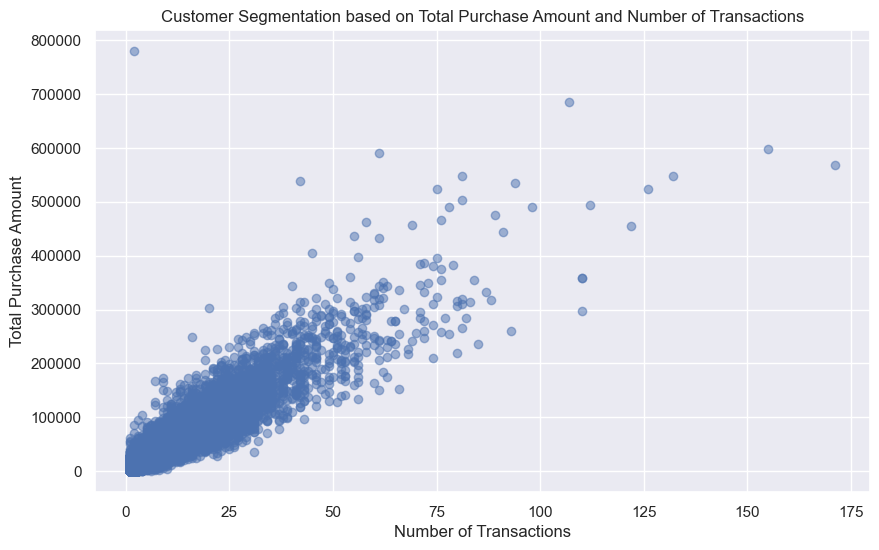

In [24]:
# Replace 'total_purchase' and 'transaction_count' with the actual column names for total purchase amount and transaction count
# Aggregate data at the customer level
customer_data = data.groupby('user_id').agg(
    total_purchase=('line_item_amount', 'sum'),  # Replace with your column name for the purchase amount
    transaction_count=('bill_id', 'nunique')     # Assuming 'bill_id' is a unique identifier for transactions
).reset_index()

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(customer_data['transaction_count'], customer_data['total_purchase'], alpha=0.5)

# Optionally, to create a bubble chart where the size of each bubble corresponds to the total purchase amount
# plt.scatter(customer_data['transaction_count'], customer_data['total_purchase'],
             #s=customer_data['total_purchase'] / 0.2, alpha=0.5)  # Adjust the denominator to scale bubble sizes appropriately

plt.title('Customer Segmentation based on Total Purchase Amount and Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Purchase Amount')
plt.grid(True)
plt.show()

# For linear regression - starting with grouped data

In [25]:
df = pd.DataFrame(data)
grouped_data = df.groupby(['product', 'colour', 'month', 'day_of_week', 'zone_name'])['line_item_amount'].sum().reset_index()
grouped_data

,product,colour,month,day_of_week,zone_name,line_item_amount
0,B,Lt Grey M.,10,0,South,3482.1372
1,B,Lt Grey M.,10,0,West,799.0000
2,B,Lt Grey M.,10,1,South,7021.7110
3,B,Lt Grey M.,10,2,South,4839.2278
4,B,Lt Grey M.,10,3,East,799.0000
...,...,...,...,...,...,...
177331,WLT,Wine,3,0,North,1.0000
177332,WLT,Wine,3,2,North,2.0323
177333,WLT,Wine,3,3,East,1599.0000
177334,WLT,Wine,4,0,North,1.0000


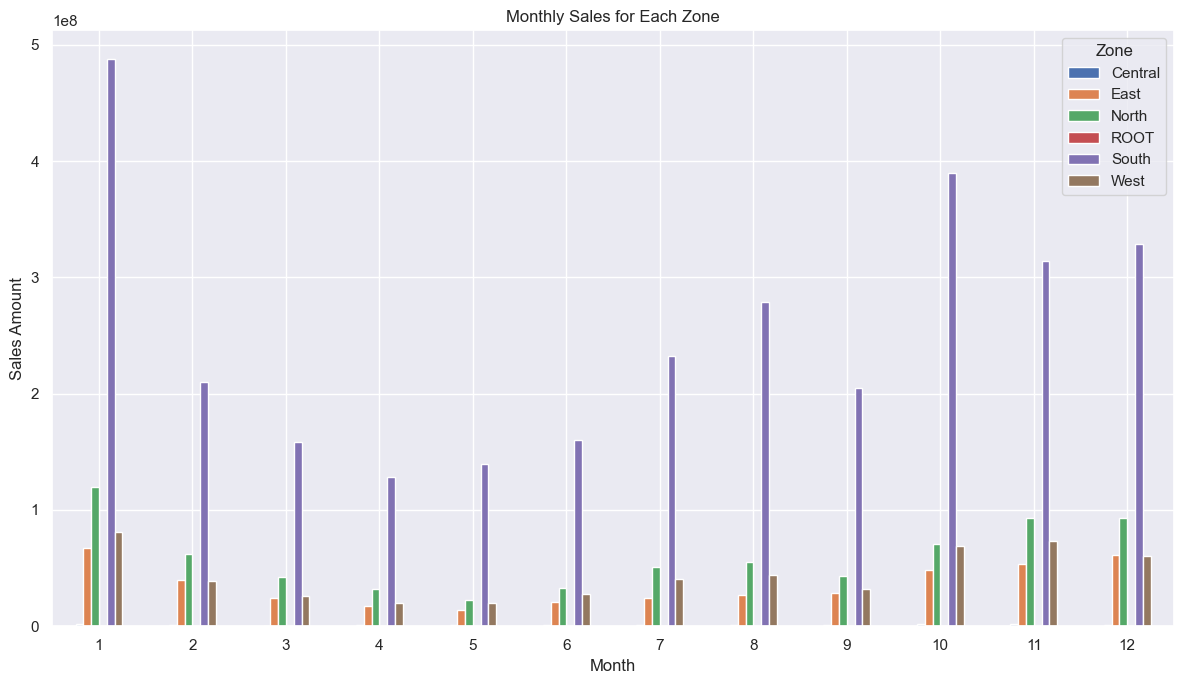

In [26]:
df1 = pd.DataFrame(data)

# Group by 'month' and 'zone_name' and sum the 'line_item_amount' for each group
monthly_sales = df1.groupby(['month', 'zone_name'])['line_item_amount'].sum().unstack(fill_value=0)

# Plotting the monthly sales for each zone
monthly_sales.plot(kind='bar', figsize=(12, 7))

plt.title('Monthly Sales for Each Zone')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.xticks(rotation=0)  # Keep the month labels horizontal
plt.legend(title='Zone')
plt.tight_layout()
plt.show()

# Encoding data for Linear Regression

In [27]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

encoded_data = pd.DataFrame(grouped_data)

# Columns to be label encoded
categorical_columns = ['product', 'colour', 'zone_name']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    # Fill NaN with a placeholder string '__MISSING__'
    # data[col] = data[col].fillna('__MISSING__')
    # Transform the categories to labels
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col])

# Check the transformation results
print(encoded_data.head())
print(len(encoded_data))

   product  colour  month  day_of_week  zone_name  line_item_amount
0        0     222     10            0          4         3482.1372
1        0     222     10            0          5          799.0000
2        0     222     10            1          4         7021.7110
3        0     222     10            2          4         4839.2278
4        0     222     10            3          1          799.0000
177336


# Correlation Matrix

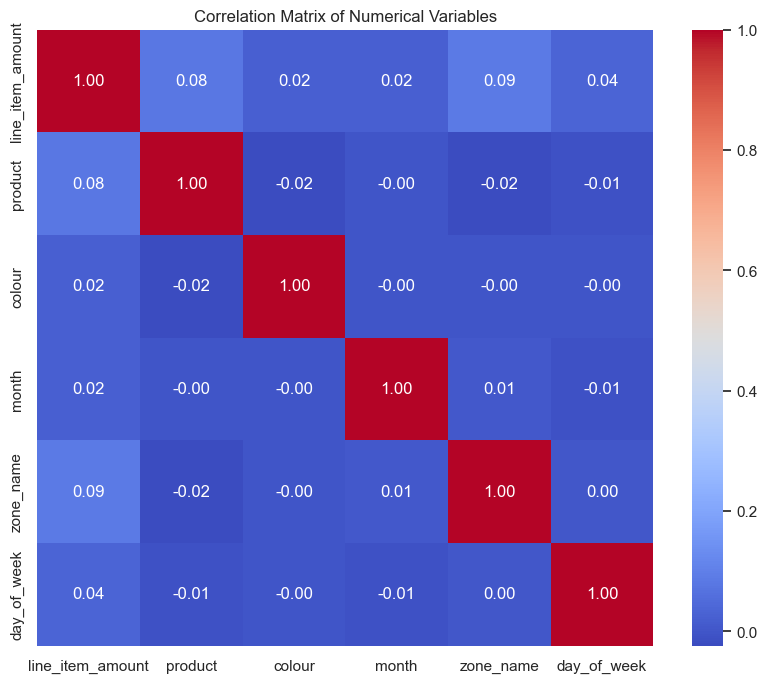

In [28]:
numerical_data = encoded_data[['line_item_amount', 'product', 'colour', 'month', 'zone_name', 'day_of_week']]

# Calculating the correlation matrix
correlation_matrix = numerical_data.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [29]:
print(data.head())

      user_id    bill_id  line_item_amount  bill_discount  day  month  \
0   519644808  741961800          559.6000            0.0   20      4   
2   504795522  692673877          699.5000            0.0   27      1   
3    12626591  768369011          519.6000            0.0    9     10   
10  496507098  779140853          559.6000            0.0   10     11   
12  518922122  740235900          937.1713            0.0    4      7   

    day_of_week  quarter  day_of_year       ic_copy      colour size  \
0             2        2          110     MENS BELT         Tan   32   
2             3        1           27     MENS BELT         Tan   34   
3             6        4          282     MENS BELT  Dark Brown   32   
10            3        4          314     MENS BELT         Tan   34   
12            0        3          185  BOYS SWEATER        Navy    L   

   zone_name  store_name       product  
0      North  North_6023     MENS BELT  
2       East   East_6510     MENS BELT  
3    

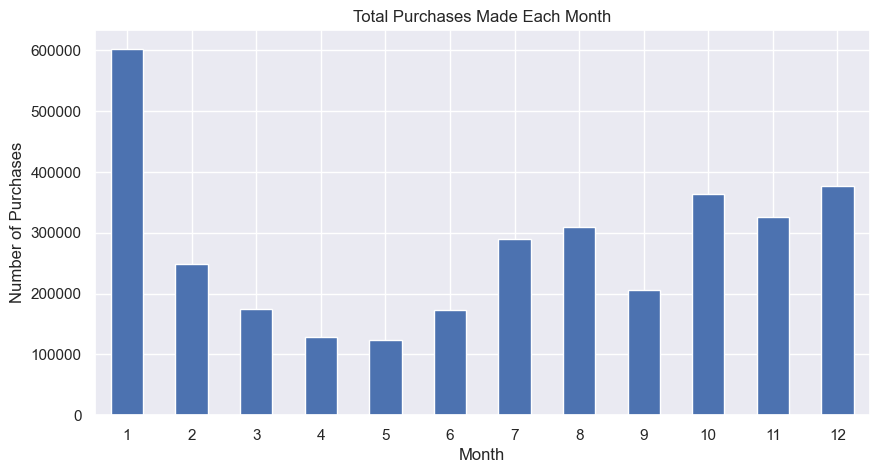

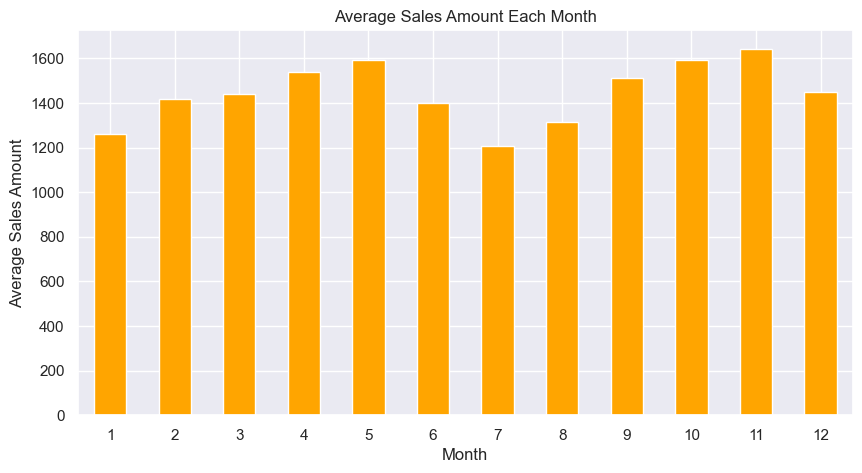

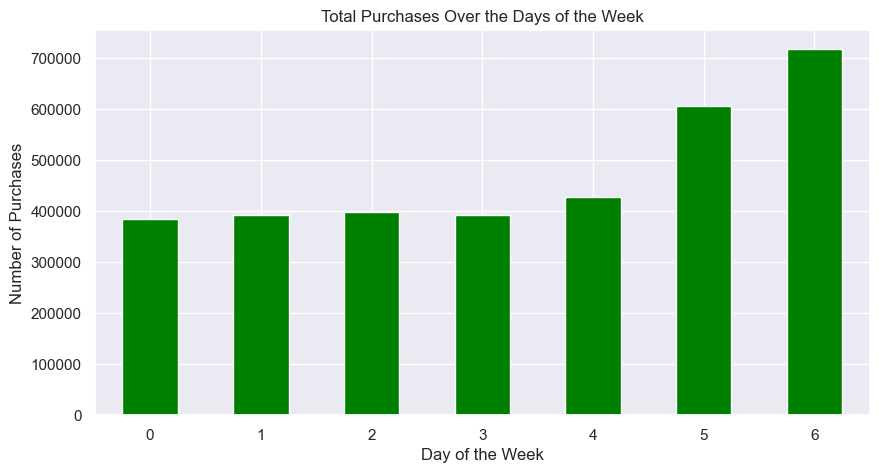

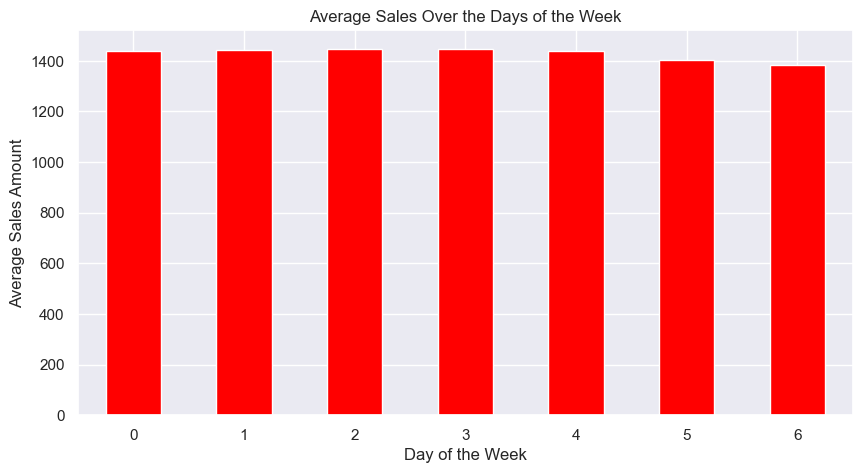

In [30]:
df = pd.DataFrame(data)

# Visualization 1: Purchases made each month
purchases_per_month = df['month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
purchases_per_month.plot(kind='bar')
plt.title('Total Purchases Made Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.show()

# Visualization 2: Average sales on each month
average_sales_per_month = df.groupby('month')['line_item_amount'].mean()
plt.figure(figsize=(10, 5))
average_sales_per_month.plot(kind='bar', color='orange')
plt.title('Average Sales Amount Each Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Amount')
plt.xticks(rotation=0)
plt.show()

# Visualization 3: Purchases done over the days of the week
purchases_per_day_of_week = df['day_of_week'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
purchases_per_day_of_week.plot(kind='bar', color='green')
plt.title('Total Purchases Over the Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.show()

# Visualization 4: Average sales over the days of the week
average_sales_per_day_of_week = df.groupby('day_of_week')['line_item_amount'].mean()
plt.figure(figsize=(10, 5))
average_sales_per_day_of_week.plot(kind='bar', color='red')
plt.title('Average Sales Over the Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales Amount')
plt.xticks(rotation=0)
plt.show()

Customer purchases

# Linear Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# Prepare your data (assuming 'line_item_amount' is the target)
X = encoded_data.drop(columns=['line_item_amount']) # Features
y = encoded_data['line_item_amount']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
poly = PolynomialFeatures(degree=3)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

y_train_log = np.log1p(y_train)# Logarithmic transformation
y_test_log = np.log1p(y_test) 


model = LinearRegression()
model.fit(X_train_scaled, y_train_log)


# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test_log, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(2.3448192519191067, -0.056848387699349745)

# Grouping Data for Artificial Neural Network

For applying the ANN - Predict which categories or items a
customer will likely purchase.

Target is product - top 10 products that you would most likely purchase

In [33]:
data.head()

,user_id,bill_id,line_item_amount,bill_discount,day,month,day_of_week,quarter,day_of_year,ic_copy,colour,size,zone_name,store_name,product
0,519644808,741961800,559.6000,0.0,20,4,2,2,110,MENS BELT,Tan,32,North,North_6023,MENS BELT
2,504795522,692673877,699.5000,0.0,27,1,3,1,27,MENS BELT,Tan,34,East,East_6510,MENS BELT
3,12626591,768369011,519.6000,0.0,9,10,6,4,282,MENS BELT,Dark Brown,32,South,South_6017,MENS BELT
10,496507098,779140853,559.6000,0.0,10,11,3,4,314,MENS BELT,Tan,34,South,South_6028,MENS BELT
12,518922122,740235900,937.1713,0.0,4,7,0,3,185,BOYS SWEATER,Navy,L,South,South_6028,BOYS SWEATER


In [34]:
grouped_data_1 = data.groupby(['user_id'])

grouped_items = df.groupby('user_id').agg({
    'product': lambda x: list(x),
    'line_item_amount': 'sum'
}).reset_index()

# Renaming columns to match the required output
grouped_items.columns = ['user_id', 'products_bought', 'total_amount']

grouped_items

,user_id,products_bought,total_amount
0,50049,"[MENS SHIRT, MENS SHIRT, MENS TROUSER WITH BELT]",3075.4242
1,50174,"[MRG, MENS TROUSER WITH BELT, MENS TROUSER WIT...",49064.8000
2,50565,"[BMK, BOYS T-SHIRT, CARRY BAG, MENS TROUSER WI...",10995.0000
3,53762,"[MENS SHIRT, MENS SHIRT, MENS SHIRT]",5397.9999
4,53796,"[MENS SHIRT, MMK, MENS SHIRT, BOYS SHIRT, MENS...",21946.9738
...,...,...,...
652068,535910369,[MENS TROUSER WITH BELT],1999.0000
652069,535910379,[MENS SHIRT],1999.0000
652070,535910444,[MENS TROUSER WITH BELT],2299.0000
652071,535910454,"[MENS SHIRT, MENS TROUSER WITH BELT]",3953.1192


In [36]:
grouped_items.head()

,user_id,products_bought,total_amount
0,50049,"[MENS SHIRT, MENS SHIRT, MENS TROUSER WITH BELT]",3075.4242
1,50174,"[MRG, MENS TROUSER WITH BELT, MENS TROUSER WIT...",49064.8000
2,50565,"[BMK, BOYS T-SHIRT, CARRY BAG, MENS TROUSER WI...",10995.0000
3,53762,"[MENS SHIRT, MENS SHIRT, MENS SHIRT]",5397.9999
4,53796,"[MENS SHIRT, MMK, MENS SHIRT, BOYS SHIRT, MENS...",21946.9738


# Encoding and scaling data for ANN

In [37]:
mlb = MultiLabelBinarizer()
product_features = mlb.fit_transform(grouped_items['products_bought'])

In [38]:
print(product_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
scaler = StandardScaler()
amount_features = scaler.fit_transform(grouped_items[['total_amount']])

In [40]:
# Combine product features and amount features
X = np.concatenate((product_features, amount_features), axis=1)
y = product_features  # The target is also the products

In [41]:
print(X)

[[ 0.          0.          0.         ...  0.          0.
  -0.32315531]
 [ 0.          0.          0.         ...  0.          0.
   3.23519219]
 [ 0.          0.          1.         ...  0.          0.
   0.28960801]
 ...
 [ 0.          0.          0.         ...  0.          0.
  -0.38322978]
 [ 0.          0.          0.         ...  0.          0.
  -0.2552452 ]
 [ 0.          0.          0.         ...  0.          0.
  -0.33680583]]


In [42]:
print(y.shape)

(652073, 42)


# Applying ANN

In [43]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mean_absolute_error'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=128)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_binarized = (y_pred > 0.5).astype(int)  # Threshold to determine if a label should be assigned


Epoch 1/20


4076/4076 [==============================] - 24s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0091
Epoch 2/20
4076/4076 [==============================] - 19s 5ms/step - loss: 1.0292e-04 - mean_absolute_error: 6.6152e-05
Epoch 3/20
4076/4076 [==============================] - 20s 5ms/step - loss: 3.7467e-05 - mean_absolute_error: 2.1597e-05
Epoch 4/20
4076/4076 [==============================] - 20s 5ms/step - loss: 2.4929e-05 - mean_absolute_error: 1.3716e-05
Epoch 5/20
4076/4076 [==============================] - 20s 5ms/step - loss: 1.6179e-05 - mean_absolute_error: 9.3352e-06
Epoch 6/20
4076/4076 [==============================] - 20s 5ms/step - loss: 1.3580e-05 - mean_absolute_error: 6.9836e-06
Epoch 7/20
4076/4076 [==============================] - 20s 5ms/step - loss: 1.5225e-05 - mean_absolute_error: 6.9024e-06
Epoch 8/20
4076/4076 [==============================] - 20s 5ms/step - loss: 1.4474e-05 - mean_absolute_error: 6.5413e-06
Epoch 9/20
4076/4076 [=======

In [50]:
from sklearn.metrics import hamming_loss
# Hamming loss
hamming_loss_value = hamming_loss(y_test, y_pred_binarized)
print(f'Hamming Loss: {hamming_loss_value}')

Hamming Loss: 2.0082410911686686e-06


# Grouping Data for Kmeans Clustering

we are trying to predict top 5 things they will buy

Do we have the data for that

1234 he has bought something
1234 has bought something else also.

1234 - A, B, C, D,......G
4321 - D, F , G... ..A


In [51]:
data.rename(columns={'ic_copy': 'inventory_category'}, inplace=True)

In [52]:
data.head()

,user_id,bill_id,line_item_amount,bill_discount,day,month,day_of_week,quarter,day_of_year,inventory_category,colour,size,zone_name,store_name,product
0,519644808,741961800,559.6000,0.0,20,4,2,2,110,MENS BELT,Tan,32,North,North_6023,MENS BELT
2,504795522,692673877,699.5000,0.0,27,1,3,1,27,MENS BELT,Tan,34,East,East_6510,MENS BELT
3,12626591,768369011,519.6000,0.0,9,10,6,4,282,MENS BELT,Dark Brown,32,South,South_6017,MENS BELT
10,496507098,779140853,559.6000,0.0,10,11,3,4,314,MENS BELT,Tan,34,South,South_6028,MENS BELT
12,518922122,740235900,937.1713,0.0,4,7,0,3,185,BOYS SWEATER,Navy,L,South,South_6028,BOYS SWEATER


In [53]:
data.shape

(3322969, 15)

In [54]:
grouped_data_kmeans = data.groupby(['bill_id'])

grouped_items_kmeans = data.groupby('bill_id').agg({
    'product': lambda x: list(x),
    'colour' :lambda y: list(y),
    'size' :lambda z: list(z),
    'line_item_amount': 'sum'
}).reset_index()

# Renaming columns to match the required output
grouped_items_kmeans.columns = ['bill_id', 'products_bought', 'colour','size','total_amount']

grouped_items_kmeans

,bill_id,products_bought,colour,size,total_amount
0,360304673,[MENS DENIM],[Dark Wash],[30],1910.2650
1,360304720,"[MENS DENIM, MENS SHIRT, MENS TROUSER WITH BEL...","[Grey, White, Stone, Light Oxy]","[36, S, 40, 36]",5562.8997
2,360305281,[MENS T-SHIRT],[Navy],[S],1506.0100
3,360305295,"[MENS SHIRT, MENS TROUSER, MENS TROUSER, MENS ...","[Sky, Stone, Dark Navy, Navy]","[M, 34, 34, L]",5247.9000
4,360305628,"[MENS SHIRT, MENS SHIRT, MENS SHIRT]","[Ochre, Navy, Gasoline]","[L, L, L]",4302.9000
...,...,...,...,...,...
1190048,797262001,[MENS TROUSER WITH BELT],[Black],[30],2299.0000
1190049,797262065,"[MENS SHIRT, MENS TROUSER WITH BELT]","[Grey, Stone]","[XL, 34]",3953.1192
1190050,797262066,[MENS TROUSER WITH BELT],[Stone],[36],2069.1000
1190051,797262071,[MENS TROUSER WITH BELT],[Olive],[34],2899.0000


# Encoding and Scaling Features for Kmeans

In [77]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans

# Assuming df is your DataFrame
#grouped_items_kmeans['products_bought'] = grouped_items_kmeans['products_bought'].apply(eval)  # Convert string representation of lists to actual lists

# One-hot encode categorical features
mlb = MultiLabelBinarizer()
products_encoded = pd.DataFrame(mlb.fit_transform(grouped_items_kmeans['products_bought']), columns=mlb.classes_, index=grouped_items_kmeans.index)
colour_encoded = pd.DataFrame(mlb.fit_transform(grouped_items_kmeans['colour']), columns=mlb.classes_, index=grouped_items_kmeans.index)
size_encoded = pd.DataFrame(mlb.fit_transform(grouped_items_kmeans['size']), columns=mlb.classes_, index=grouped_items_kmeans.index)

# Combine one-hot encoded features with other numerical features
numerical_features = ['total_amount']
grouped_items_kmeans_encoded = pd.concat([products_encoded,colour_encoded,size_encoded,grouped_items_kmeans[numerical_features]], axis=1)

# Standardize numerical features
scaler = StandardScaler()
grouped_items_kmeans_encoded[numerical_features] = scaler.fit_transform(grouped_items_kmeans_encoded[numerical_features])




# Applying KMeans Clustering on Grouped Data

In [ ]:
# Apply k-means clustering
k = 3  # You can choose the number of clusters based on your understanding of the data
kmeans = KMeans(n_clusters=k, random_state=42)

grouped_items_kmeans['cluster'] = kmeans.fit_predict(grouped_items_kmeans_encoded)


In [80]:
# Display the resulting DataFrame with cluster assignments
print(items_kmeans_filtered[['bill_id', 'products_bought', 'cluster']])

           bill_id                                    products_bought  cluster
1        360304720  [MENS DENIM, MENS SHIRT, MENS TROUSER WITH BEL...        6
3        360305295  [MENS SHIRT, MENS TROUSER, MENS TROUSER, MENS ...        6
4        360305628               [MENS SHIRT, MENS SHIRT, MENS SHIRT]       22
5        360305704  [MENS TROUSER, MENS TROUSER, MENS TROUSER, MEN...        6
10       360306431               [MENS DENIM, MENS DENIM, MENS DENIM]        6
...            ...                                                ...      ...
1189942  795187830  [MENS TROUSER WITH BELT, MENS TROUSER WITH BEL...        6
1189967  795210351  [MENS TROUSER WITH BELT, MENS TROUSER WITH BEL...        6
1189968  795211529  [MENS TROUSER WITH BELT, MENS TROUSER WITH BEL...        6
1190014  797261116  [MENS TROUSER WITH BELT, MENS TROUSER WITH BEL...        6
1190040  797261462  [MENS TROUSER WITH BELT, MENS TROUSER WITH BEL...        6

[549301 rows x 3 columns]


In [83]:
k_values = range(1, 11)

# List to store inertias for each k
inertias = []

# Fit k-means for each value of k and store inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(grouped_items_kmeans_encoded)
    inertias.append(kmeans.inertia_)



E:\New_folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\New_folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\New_folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\New_folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

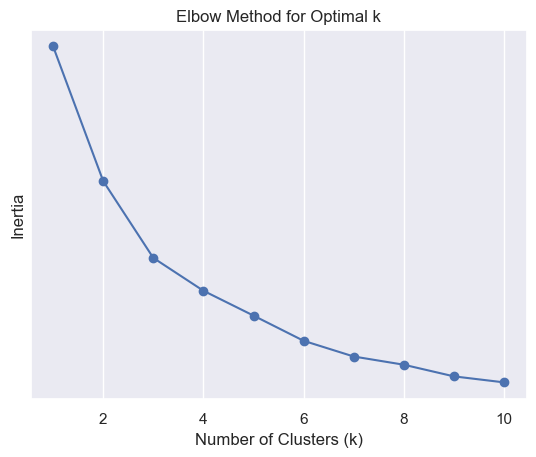

In [84]:
# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.yticks([])
plt.show()